# Statistical analysis of incident probability and causes on RATP metro lines

## Methodology

The official RATP Twitter accounts frequently update operational status of their lines like the following one. In this case, at 16:46 the line 1 account reports an operational incident (the line is cut between two stations) due to a technical problem (very strange one...they have some difficulty managing the line 😂)

<img width="450" src="https://user-images.githubusercontent.com/4027283/52820320-f9343580-30ab-11e9-8f15-4f337cd4a4ae.png">

With the Python script contained in this notebook, the three *highlighted* information in this tweet is converted to a line inside a pandas dataframe (a table) containing mainly three columns:

1. `time`: every day is divided into 24 *exact* hours: 00:00 – 00:59, ..., 23:00 – 23:59.
2. `is_incident`: if an incident (or more) is reported during this hour.
3. `incident_cause`: the cause of the incident. In case of several incidents, record the most frequent cause. In general it's still rare to have two separate incidents of different nature.

| `time`                   | `is_incident` | `incident_cause` |
| ------------------------ | ------------- | ---------------- |
| ...                      |               |                  |
| 2019-02-14 15:00 – 15:59 | `False`       | N/A              |
| 2019-02-14 16:00 – 16:59 | `True`        | technique        |
| 2019-02-14 17:00 – 17:59 | `False`       | N/A              |
| ...                      |               |                  |

Since the time of incident is recorded to be only accurate to the hour, the statistical results reported below should be interprepted with caution. For instance, if I announce that in the hour 17:00 – 17:59 the probability of encountering incidents on metro line 2 is 3%, that's all...I have no further statistical information on when exactly the incident may happen MORE LIKELY in that hour. It may happen that actually more incidents may take place from 17:45 to 17:59, but no estimation can be made with the current design, due to the partitioning of one day only to 24 hours.

## Source code

Feel free to skip if you do not want to know the details.

We define a Python class `RATPTweets`, to be instantiated with an integer $1\leq l\leq 14$ (`line`) corresponding to the RATP metro line you want to analyze. This class implements the following functions

1. `load(number_of_tweets=3200, force=False)`: download the tweets from the official RATP Twitter account. Due to some limitation of the Twitter API, you can only download up to 3200 tweets. You can set the `number_of_tweets` variable to download less. The downloaded tweets are put in a `tweets` folder, and it will directly load the already downloaded file without re-downloading it. You can force downloading by using `force=True`.
2. `process()`: process the downloaded raw data (using Paris time zone, identifying incidents, resampling...)
3. `mean_incident_prob(year=None)`: compute the average probability of incidents (within a specific year if `year` is given). If `year` is not given, then all downloaded tweets are used.
4. `plot_prob(by="hour", year=None)`: plot the (margional) probability of incidents with respect to `by`: `year`, `month`, `day`, `weekday`, `hour` or any two of them connected by a "-"
5. `plot_cause(year=None)`: plot the most frequent causes of incidents

To be able to download tweets you need to manually enter your Twitter developer API keys (`consumer_key`, `consumer_secret`, `access_key` and `access_secret`). Be aware that it's not possible to download all 14 lines on a row: there is some usage limitation of the Twitter API.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14,
          "savefig.bbox": "tight",
          "savefig.pad_inches": 0.01}
plt.rcParams.update(params)

pd.set_option("display.max_colwidth", 150)

In [2]:
consumer_key = ""
consumer_secret = ""
access_key = ""
access_secret = ""

In [3]:
class RATPTweets():
    
    def __init__(self, line):
        self.line = line
        self.df = None
        self.df_processed = None
        
        self._define_incidents()
        self._define_color()
    
    def _define_incidents(self):
        """
        Define some keywords for identifying incidents from RATP tweets
        """
        # Keywords for operational incidents
        self.incident_words = ["perturbé", "interrompu", "ralenti"]
        
        # Incident causes and their keywords
        # Question: incident voie  -> autre ?
        #           diver incident -> autre ?
        # Some tweets are incomplete (thank you Twitter), like this one
        # > 07:56, le trafic est interrompu entre Chaussee d'Antin (La Fayette)
        # > et Trocadero. Reprise estimée à 09:00. (Personn… https://t.co/ZPsJrIlZBG
        # since the cause is not complete (even though it should be "voyageur",
        # it can only be classified as "autre"
        self.incident_causes = {
            "colis": ["colis", "bagage"],
            "technique": ["technique", "panne", "exploitation", "fumée", "rail",
                          "aiguillage"],
            "voyageur": ["voyageur", "personne", "malveillance", "signal d'alarme",
                         "affluence"],
#             "chantier": ["chantier"],  # "fin tartive de chantier", in general not so much so -> autre
            "manifestation": ["mesure de sécurité"]  # better name for this (in case of terrorist attacks also)?
        }
        self.incident_cause_other = "autre"
    
    def _define_color(self):
        """
        Define the color to be used for the current metro line when plotting
        
        Source: https://data.ratp.fr/explore/dataset/pictogrammes-des-lignes-de-metro-rer-tramway-bus-et-noctilien/information
        """
        color_line = {}
        color_line[1] = "#FFBE00"
        color_line[2] = "#0055C8"
        color_line[3] = "#6E6E00"
        color_line[4] = "#A0006E"
        color_line[5] = "#FF5A00"
        color_line[6] = "#82DC73"
        color_line[7] = "#FF82B4"
        color_line[8] = "#D282BE"
        color_line[9] = "#D2D200"
        color_line[10] = "#DC9600"
        color_line[11] = "#6E491E"
        color_line[12] = "#00643C"
        color_line[13] = "#82C8E6"
        color_line[14] = "#640082"
        color_line["A"] = "#FF1400"
        color_line["B"] = "#3C91DC"
        self.color = color_line[self.line]

    def load(self, number_of_tweets=3200, force=False):
        """
        Download tweets from the RATP account, adapted from https://github.com/gitlaura/get_tweets/
        """
        import os
        import csv
        import tweepy

        username = self._twitter_account()
        outfile = os.path.join("tweets", username + ".csv")
        if not os.path.isfile(outfile) or force:
            auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_key, access_secret)
            api = tweepy.API(auth, wait_on_rate_limit=True)

            tweets_for_csv = [["time", "tweet"]]
            print(f"Downloading tweets for {username}")
            for tweet in tweepy.Cursor(api.user_timeline, screen_name=username).items(number_of_tweets):
                tweets_for_csv.append([tweet.created_at, tweet.text])

            with open(outfile, "w", newline="") as f:
                writer = csv.writer(f, delimiter=',')
                writer.writerows(tweets_for_csv)

        self.df = pd.read_csv(outfile)
    
    def process(self):
        """
        Process the downloaded raw data frame
        """
        assert self.df is not None
        
        # Convert to Paris time
        self.df["time"] = pd.DatetimeIndex(pd.to_datetime(self.df["time"]))
        self.df = self.df.set_index("time")
        self.df = self.df.tz_localize("UTC")
        self.df = self.df.tz_convert("Europe/Paris")
        self.df = self.df.sort_index()
        
        # Detect incidents from tweets
        self.df[["is_incident", "incident_cause"]] = self.df["tweet"].apply(self._detect_incident)
        
        # Uniformly resample timestamps every hour and extract time information
        self.df_processed = self.df.drop(["tweet"], axis=1)
        self.df_processed = self.df_processed.resample("H").agg(
            {"is_incident": np.any, "incident_cause": self._agg_incident_cause})
        for x in ["year", "month", "day", "weekday", "hour"]:
            self.df_processed[x] = eval(f"self.df_processed.index.{x}")
    
    def mean_incident_prob(self, year=None):
        """
        Return the mean probability of operational incidents
        
        - if "year" is not given, use all the tweets downloaded
        """
        df = self._df_processed_loc_year(year)
        return df["is_incident"].mean()
    
    def plot_cause(self, year=None):
        """
        Plot frequencies of the main cause of incidents
        
        - if "year" is not given, use all the tweets downloaded
        """
        df = self._df_processed_loc_year(year)
        incident_cause = df["incident_cause"].value_counts().drop(["N/A"])
        incident_cause.plot(kind="pie", autopct="%.0f%%")
        plt.ylabel("")
        return incident_cause.index, incident_cause.values
    
    def plot_prob(self, by="hour", year=None, **kwargs):
        """
        Plot (marginal) probability of operational incidents
        
        - "by" can be "year", "month", "day", "weekday", "hour", or any two of them
          connected by a "-", like "hour-weekday"
        - if "year" is not given, use all the tweets downloaded
        """
        if "year" in by:
            year = None
        df = self._df_processed_loc_year(year)
        
        # Extract "by" for 2d plots
        if "-" in by:
            by_x, by_y = by.split("-")
            assert by_x in df
            assert by_y in df
        else:
            assert by in df
        
        weekday_label = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
        
        # 2d plot
        if "-" in by:
            df = df.groupby([by_x, by_y]).mean()["is_incident"]
            x, y = df.index.levels  # already sorted
            x1 = list(x) + [2 * x[-1] - x[-2]]
            y1 = list(y) + [2 * y[-1] - y[-2]]
            xx, yy = np.meshgrid(x1, y1, indexing="ij")
            c = np.zeros((len(x), len(y)))
            for i in range(len(x)):
                for j in range(len(y)):
                    index = xx[i, j], yy[i, j]
                    if index in df:
                        c[i, j] = df[index]
                    else:  # data not available
                        c[i, j] = np.nan
            plt.pcolormesh(xx, yy, c, cmap="Reds", **kwargs)
            
            # Center year, month, day, weekday to the ticks center
            for by, label, set_ticks in zip([by_x, by_y], [x, y], [plt.xticks, plt.yticks]):
                ticks = np.linspace(label[0] + 0.5, label[-1] + 0.5, len(label))
                if by == "year":
                    pass
                elif by == "month":
                    ticks = ticks[::2]
                    label = label[::2]
                elif by == "day":
                    ticks = ticks[::5]
                    label = label[::5]
                elif by == "weekday":
                    label = weekday_label
                else:  # "hour":
                    break
                set_ticks(ticks, label)
            
            plt.xlabel(by_x)
            plt.ylabel(by_y)
            plt.colorbar(format=FuncFormatter(lambda y, _: "{:.1%}".format(y)))
            plt.title("probability of incidents")
            return xx, yy, c
        
        # 1d plot
        else:
            df = df.groupby(by).mean()["is_incident"]
            y = df.values
            if by == "weekday":
                x = weekday_label
            else:
                x = df.index

            plt.plot(x, y, "-o", color=self.color, **kwargs)
            plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.1%}".format(x))) 
            plt.xlabel(by)
            plt.ylabel("probability of incidents")
            plt.grid()
            return x, y

    def _twitter_account(self):
        """
        Return the official RATP twitter account
        """

        # Metro
        if type(self.line) == int:
            assert 1 <= self.line <= 14
            return f"Ligne{self.line}_RATP"

        # RER A or B
        elif self.line == "A":
            return "RER_A"
        elif self.line == "B":
            return "RER_B"
        else:
            print('line must be a number between 1 and 14, "A", or "B".')
            return None

    def _classify_incident_cause(self, cause):
        """
        Classify the cause of operational incident
        """
        cause = cause.lower().strip()
        for main_cause, keywords in self.incident_causes.items():
            for keyword in keywords:
                if keyword in cause:
                    return main_cause
        else:
            return self.incident_cause_other
    
    def _agg_incident_cause(self, cause):
        """
        Given a list of causes found by self._classify_incident_cause,
        return the most common cause (useful when resampling)
        """
        cause = list(filter(("N/A").__ne__, cause))  # remove N/A
        if len(cause) > 0:
            return max(set(cause), key=cause.count)
        else:
            return "N/A"
    
    def _df_processed_loc_year(self, year=None):
        """
        Return self.df_processed within the given year
        """
        assert self.df is not None
        if self.df_processed is None:
            self.process()
        
        # Focus on a specific year
        if year is not None:
            df = self.df_processed.loc[f"{year}-01-01":f"{year}-12-31"]
        else:
            df = self.df_processed
        return df
    
    def _detect_incident(self, tweet):
        """
        Read a tweet message from the RATP official accounts and detect if it announces
        some operational incidents
        
        1. All tweets concerning operational states
           (*perturbé*, *repart*, *rétabli*, *interrompu*, ...)
           are assumed to ALWAYS start with the current time (10:21 for instance).
        2. The cause (*colis suspect* for example) is contained within the last parentheses.
        3. Only consider tweets from the current line (sometimes they retweet messages
           from other lines...)
        
        TODO: the tweet time (in self.df.index) and the time reported for the incident
              in general do not match (but differ not much...
              depending on the reactivity of RATP?). Ideally we should replace the tweet
              time by the reported time to accurately locate the incident.

        return (is_incident, incident_cause)
        """
        if tweet.startswith("RT"):
            return pd.Series([False, "N/A"])  # no incident identified, cause not available
        
        tweet = tweet.lower()
        part_before_first_comma = tweet.partition(",")[0]
        try:
            time = pd.to_datetime(part_before_first_comma, format="%H:%M")
            for word in self.incident_words:
                if word in tweet:
                    break
            else:
                return pd.Series([False, "N/A"])
            cause = tweet.rpartition("(")[2]
            if cause == "":
                cause = "N/F"  # not found
            else:
                cause = self._classify_incident_cause(cause)
            return pd.Series([True, cause])
        except ValueError:
            return pd.Series([False, "N/A"])

## First example with the RATP metro line 2

We will first take an example of the metro line 2 (which I take everyday for my work), in the year 2018. In the `RATPTweets` class, you can find a pandas dataframe `df` containing the raw tweets downloaded from the official RATP Twitter account. After processing (using the method `process()`) two additional columns will appear

1. `is_incident`: whether the current tweet reports an incident (True or False)
2. `incident_cause`: the cause of this incident

An example with the last 10 tweets.

In [4]:
line2 = RATPTweets(line=2)
line2.load()
line2.process()
line2.df.tail(10)

,tweet,is_incident,incident_cause
time,,,
2019-02-12 08:52:29+01:00,"08:51, la rame stationne à Jaures en dir. de Nation (malaise voyageur) #RATP #ligne2",False,N/A
2019-02-12 08:57:28+01:00,"08:55, le trafic est perturbé sur la ligne (malaise voyageur) #RATP #ligne2",True,voyageur
2019-02-12 09:40:32+01:00,"09:39, le trafic est rétabli sur la ligne (malaise voyageur) #RATP #ligne2",False,N/A
2019-02-13 08:53:28+01:00,"08:52, le trafic est perturbé sur la ligne (incident technique) #RATP #ligne2",True,technique
2019-02-13 08:57:29+01:00,"@Berlin_Mule Bonjour, il y a in incident technique à Place de Clichy ce qui implique un ralentissement à 10 km/h su… https://t.co/5Pw9UQdkFa",False,N/A
2019-02-13 09:43:25+01:00,Une interruption entre Barbés et CDG Étoile est prévue dans quelques instants pour permettre à nos mainteneurs… https://t.co/dif1Hebq0g,False,N/A
2019-02-13 09:48:28+01:00,"09:47, le trafic est interrompu entre Barbes-Rochechouart et Etoile. Reprise estimée à 10:00. (incident technique) #RATP #ligne2",True,technique
2019-02-13 09:53:29+01:00,"09:52, le trafic est interrompu entre Barbes-Rochechouart et Etoile. Reprise estimée à 10:15. (incident technique) #RATP #ligne2",True,technique
2019-02-13 10:12:35+01:00,"10:11, le trafic reprend progressivement sur la ligne (incident technique) #RATP #ligne2",False,N/A


### Mean probability of operational incidents

The average probability of encountering incidents in the year 2018 is expected to be 1.9%.

In [5]:
line2.mean_incident_prob(year=2018)

0.01872146118721461

### Variation in the probability of incidents

The probability of encountering problems is by no means a constant value. Around 04:00 all metro systems are closed so it's impossible to catch one! In the meanwhile at rush hours you are more likely to hate RATP metros. That's why we propose a `plot_prob(by="hour", year=None)` method capable of plotting (aggregated, marginal) probability variation with respect to a given variable.

#### By hour

Here the value refers in fact to the next following hour starting from this value. For example, the value of 9 below refers to the hour begining from 09:00 to 09:59.

1. As said before it's natural to have lower probabilities of having problems when everyone sleeps (from midnight to 04:59): even the metro does!
2. We get a first peak in the morning from 08:00 to 09:59, where the probability of having problems is 3%.
3. The maximal probability of 4% can be found from 18:00 to 18:59.

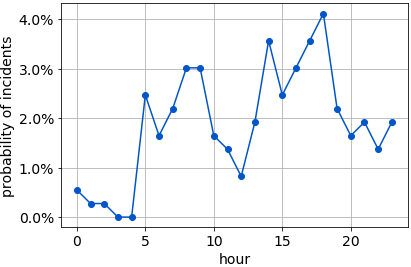

In [26]:
line2.plot_prob(by="hour", year=2018)
plt.tight_layout()

#### By weekday

1. On Tuesday I may have more problems on the line 2.
2. It's better to take the line 2 on weekends...especially on Sunday!

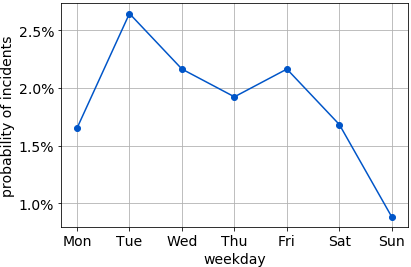

In [27]:
line2.plot_prob(by="weekday", year=2018)
plt.tight_layout()

#### By hour-weekday

This representation is more accurate as it tells us the probability of incidents for a given hour (in fact in the next following hour) and a specific weekday.

1. Black Wednesday when I leave work at 18:00, as there is nearly 9% chance that the line 2 will not work properly!
2. Also lots of problems On Tuesday when I go to work from 08:00 to 09:59.
3. No problem at all on Sunday until 18:00!

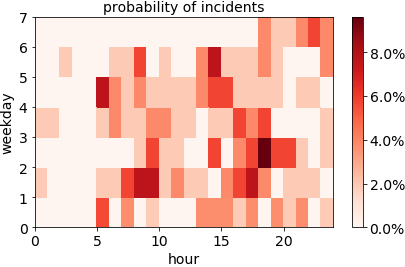

In [32]:
line2.plot_prob(by="hour-weekday", year=2018)
plt.tight_layout()

#### By month

1. People on the line 2 take lots of vacations!! On Janurary, May (because of *ponts*?), Auguest and September.
2. Yes, both on Auguest and September.

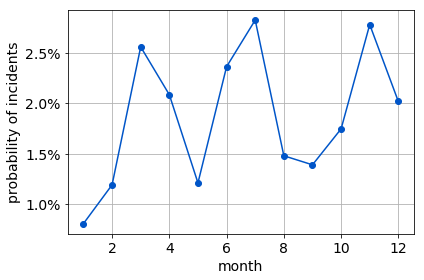

In [8]:
line2.plot_prob(by="month", year=2018)
plt.tight_layout()

#### By month-weekday

1. In November never take line 2 on Wednesday.

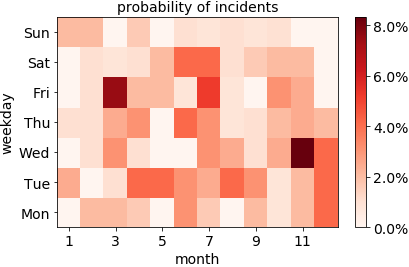

In [50]:
line2.plot_prob(by="month-weekday", year=2018)
plt.tight_layout()

#### By year

1. Because of the election of E. M. ??

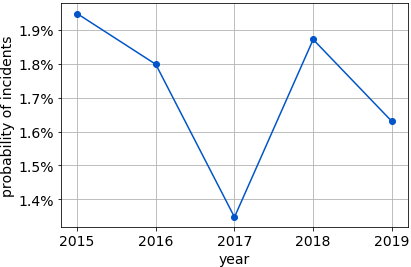

In [36]:
line2.plot_prob(by="year")
plt.tight_layout()

#### By month-year

1. When data is not available, the case will be blank (begining of 2015 due to lack of tweets, and after Feburary since it's in the future).

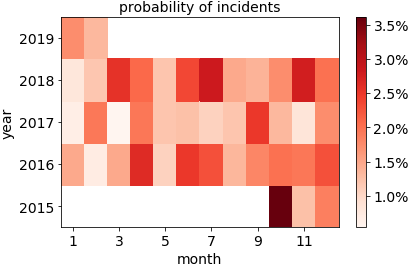

In [48]:
line2.plot_prob(by="month-year")
plt.tight_layout()

### Most frequent incidents causes

It seems that nearly half of the incidents come from us. Also, 9% is due to unattended bags...

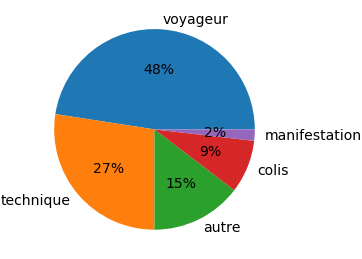

In [14]:
line2.plot_cause(year=2018)
plt.tight_layout()

## All RATP metro lines

In [11]:
ratp_line = {}
lines = np.arange(1, 15)
for line in lines:
    ratp_line[line] = RATPTweets(line=int(line))
    ratp_line[line].load()

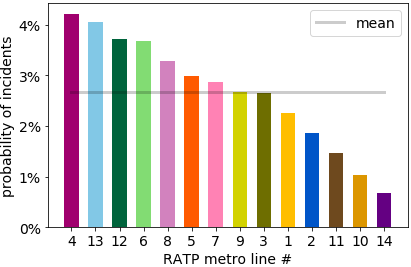

In [12]:
mean_incident_prob = np.zeros(len(lines))
color = [None] * len(lines)
for i, line in enumerate(lines):
    mean_incident_prob[i] = ratp_line[line].mean_incident_prob(year=2018)
    color[i] = ratp_line[line].color

idx = np.argsort(mean_incident_prob)[::-1]  # descending order
x = lines[idx]
y = mean_incident_prob[idx]
color = np.array(color)[idx]
plt.bar(lines, y, width=0.6, color=color)

mean = mean_incident_prob.mean()
plt.plot((lines.min(), lines.max()), (mean, mean), "k-", linewidth=3, alpha=0.2, label="mean")

plt.xticks(lines, x)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
plt.xlabel("RATP metro line #")
plt.ylabel("probability of incidents")
plt.legend()
plt.tight_layout()

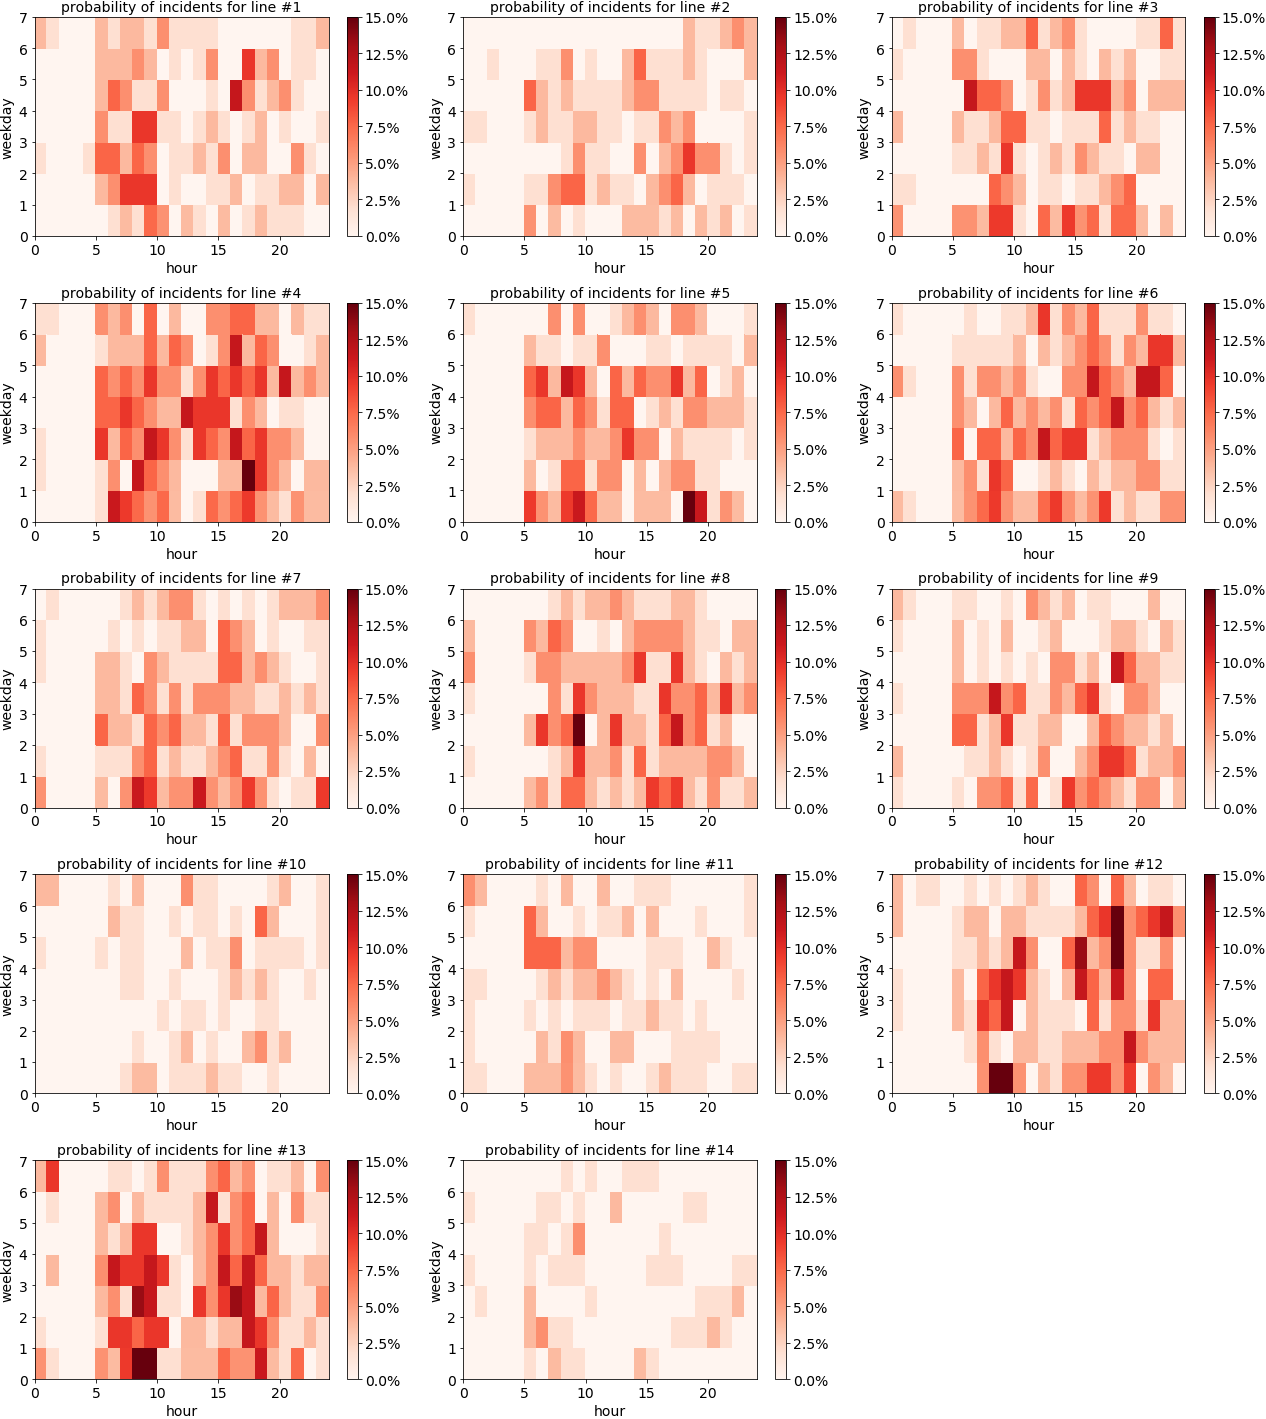

In [13]:
c_mean = np.zeros((len(lines), 24, 7))
plt.figure(figsize=(18, 20))
for i, line in enumerate(lines):
    plt.subplot(5, 3, i + 1)
    xx, yy, c_mean[i] = ratp_line[line].plot_prob(by="hour-weekday", year=2018, vmax=0.15)
    plt.title(plt.gca().get_title() + " for line #" + str(line))

plt.tight_layout()

### Mean probability of incidents by hour and weekday among all lines

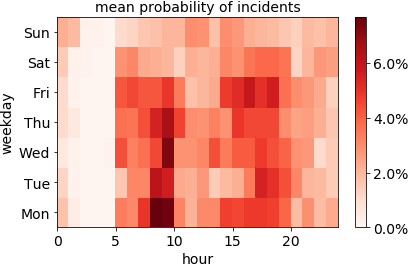

In [14]:
plt.pcolormesh(xx, yy, c_mean.mean(axis=0), cmap="Reds")
plt.yticks(np.linspace(0.5, 6.5, 7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xlabel("hour")
plt.ylabel("weekday")
plt.colorbar(format=FuncFormatter(lambda y, _: "{:.1%}".format(y)))
plt.title("mean probability of incidents")
plt.tight_layout()

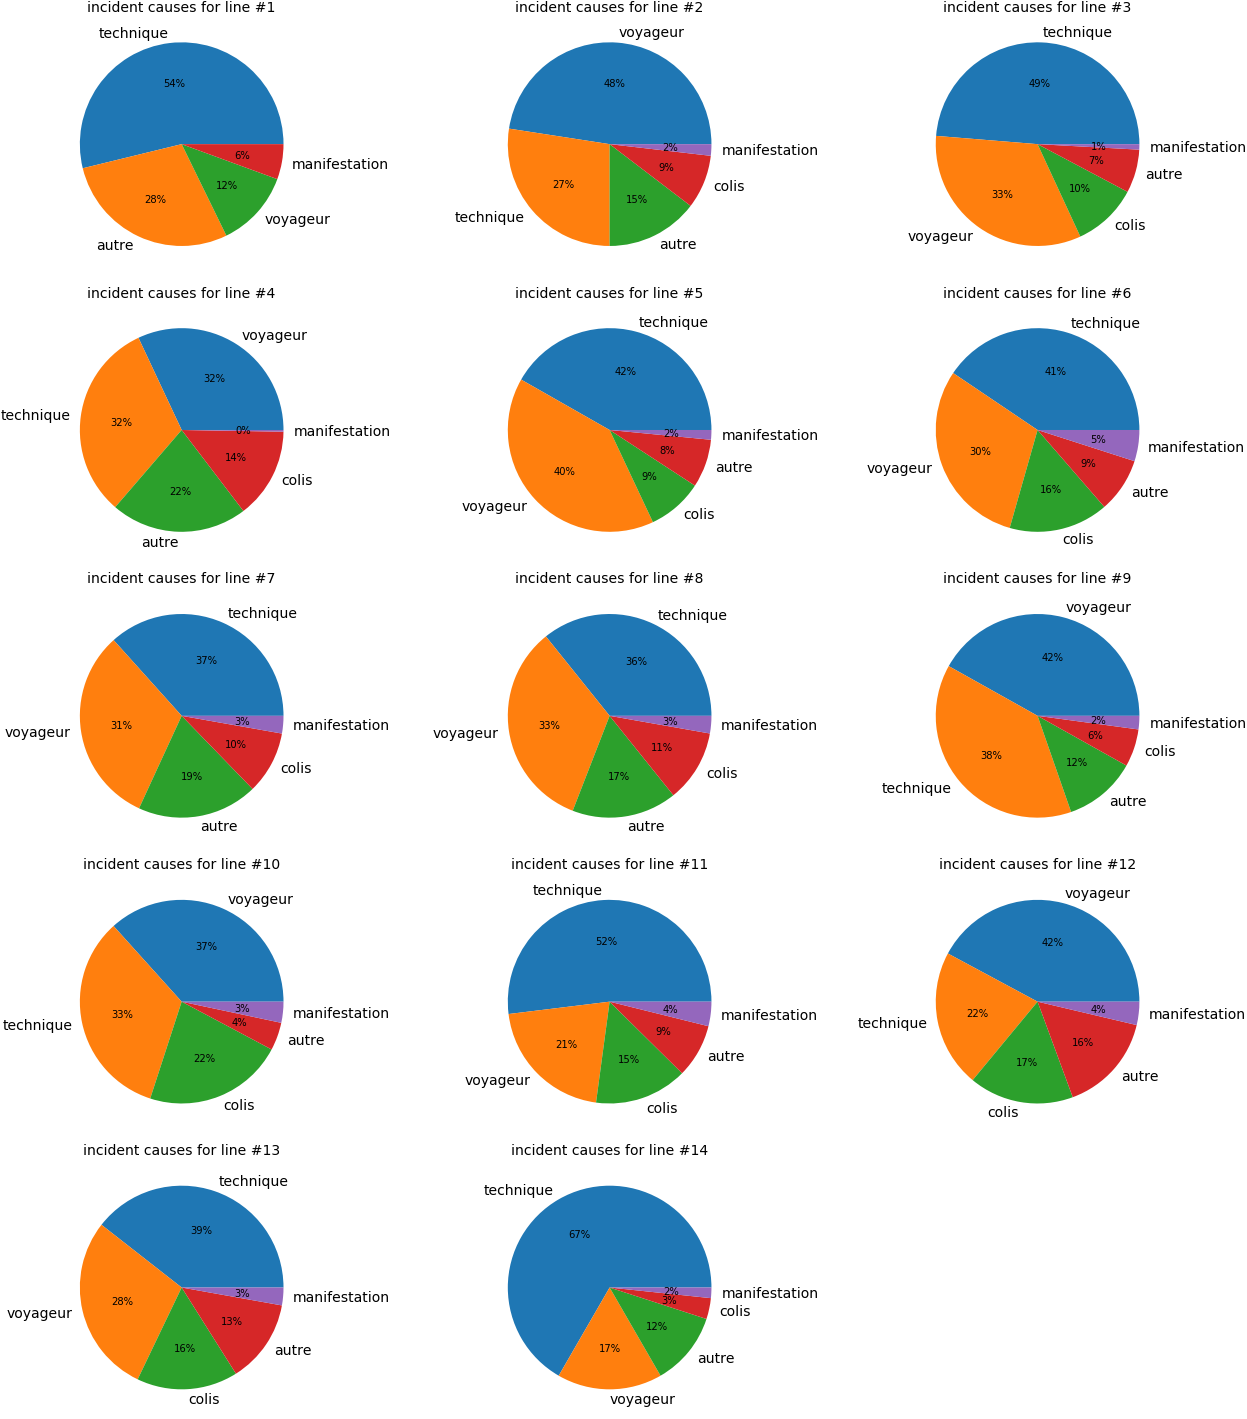

In [15]:
most_freq_cause = [None] * len(lines)
plt.figure(figsize=(18, 20))
for i, line in enumerate(lines):
    plt.subplot(5, 3, i + 1)
    causes, _ = ratp_line[line].plot_cause(year=2018)
    most_freq_cause[i] = causes[0]
    plt.title("incident causes for line #" + str(line))

plt.tight_layout()

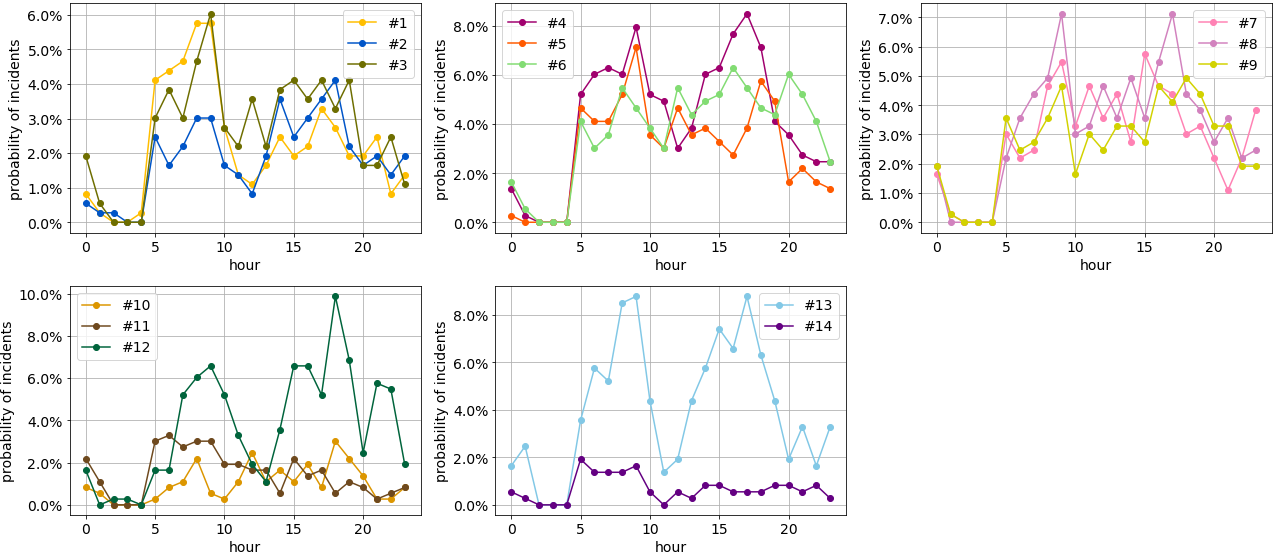

In [16]:
plt.figure(figsize=(18, 8))
lines_split = np.array_split(lines, 5)
incident_prob_hour_line = np.zeros((len(lines), 24))
for i, split in enumerate(lines_split):
    plt.subplot(2, 3, i + 1)
    for line in split:
        x, incident_prob_hour_line[line - 1] = ratp_line[line].plot_prob(by="hour", year=2018)
    plt.legend(["#" + str(x) for x in split])

plt.grid()
plt.tight_layout()

### Mean probability of incidents by hour among all lines

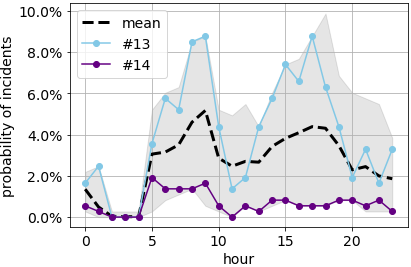

In [17]:
incident_prob_hour_line_mean = incident_prob_hour_line.mean(axis=0)
incident_prob_hour_line_min = incident_prob_hour_line.min(axis=0)
incident_prob_hour_line_max = incident_prob_hour_line.max(axis=0)
hour = range(24)
plt.plot(hour, incident_prob_hour_line_mean, "k--", linewidth=3)
plt.fill_between(hour, incident_prob_hour_line_min, incident_prob_hour_line_max, color="k", alpha=0.1)

ratp_line[13].plot_prob(by="hour", year=2018)
ratp_line[14].plot_prob(by="hour", year=2018)

plt.legend(["mean", "#13", "#14"])
plt.grid()
plt.tight_layout()

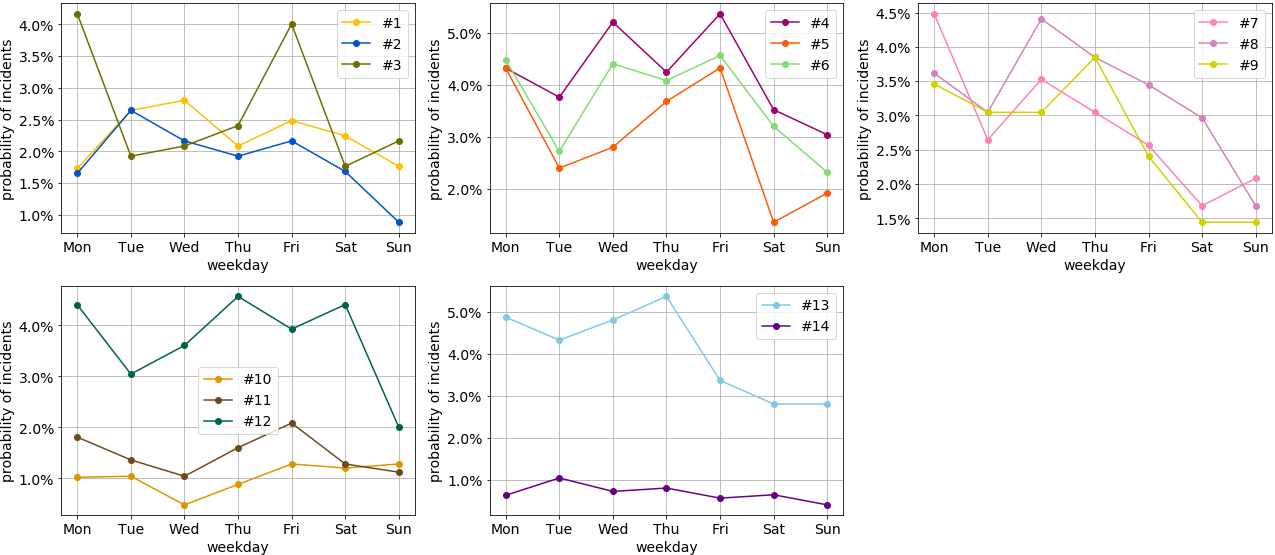

In [18]:
plt.figure(figsize=(18, 8))
lines_split = np.array_split(lines, 5)
for i, split in enumerate(lines_split):
    plt.subplot(2, 3, i + 1)
    for line in split:
        ratp_line[line].plot_prob(by="weekday", year=2018)
    plt.legend(["#" + str(x) for x in split])

plt.grid()
plt.tight_layout()

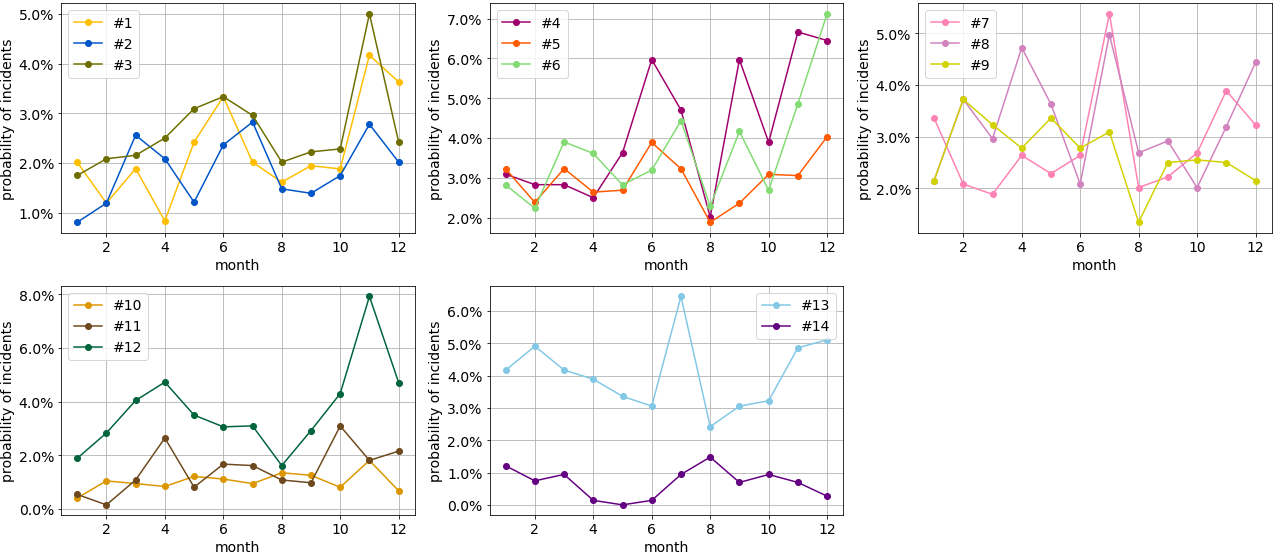

In [19]:
plt.figure(figsize=(18, 8))
lines_split = np.array_split(lines, 5)
for i, split in enumerate(lines_split):
    plt.subplot(2, 3, i + 1)
    for line in split:
        ratp_line[line].plot_prob(by="month", year=2018)
    plt.legend(["#" + str(x) for x in split])

plt.grid()
plt.tight_layout()

## Further analyses

### More incidents at rush hours?

The rush hours are defined as from 08:00 to 09:59 and from 17:00 to 19:59. 

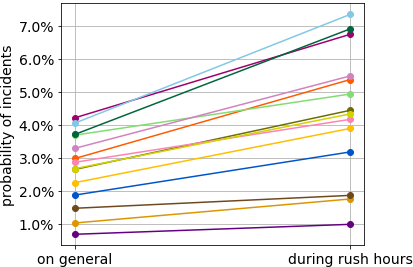

In [20]:
def plot_bar_comparison(mask_string, label, year=2018):
    mask = np.zeros_like(mean_incident_prob)
    for i, line in enumerate(lines):
        df = ratp_line[line]._df_processed_loc_year(year=year)
        mask[i] = df[eval(mask_string)]["is_incident"].mean()

    all_mean = mean_incident_prob.mean()
    all_min = mean_incident_prob.min(); all_min_who = mean_incident_prob.argmin() + 1
    all_max = mean_incident_prob.max(); all_max_who = mean_incident_prob.argmax() + 1
    mask_mean = mask.mean()
    mask_min = mask.min(); mask_min_who = mask.argmin() + 1
    mask_max = mask.max(); mask_max_who = mask.argmax() + 1
    yerr = np.array([[all_mean - all_min, mask_mean - mask_min],
                     [all_max - all_mean, mask_max - mask_mean]])
    x = [0, 1]
    dx = 0.02
    dy = 0.001
    plt.bar(x, [all_mean, mask_mean], width=0.4, yerr=yerr, color=["C0", "C1"])
    plt.text(x[0] + dx, all_min + dy, f"#{all_min_who}", fontsize=14)
    plt.text(x[0] + dx, all_max - dy, f"#{all_max_who}", fontsize=14)
    plt.text(x[1] + dx, mask_min + dy, f"#{mask_min_who}", fontsize=14)
    plt.text(x[1] + dx, mask_max - dy, f"#{mask_max_who}", fontsize=14)

    plt.xticks(x, ["on general", label])
    plt.ylabel("probability of incidents")
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.1%}".format(x))) 
    plt.tight_layout()

def plot_parallel_comparison(mask_string, label, year=2018):
    x = [0, 1]
    for line in lines:
        df = ratp_line[line]._df_processed_loc_year(year=year)
        mask = df[eval(mask_string)]["is_incident"].mean()
        plt.plot(x, [mean_incident_prob[line - 1], mask], "-o", color=ratp_line[line].color)

    plt.xticks(x, ["on general", label])
    plt.ylabel("probability of incidents")
    plt.grid()
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.1%}".format(x))) 
    plt.tight_layout()

plot_parallel_comparison("df['hour'].isin([8, 9, 17, 18, 19])", "during rush hours")

### Less incidents during weekend?

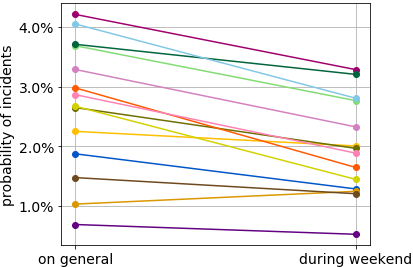

In [21]:
plot_parallel_comparison("df['weekday'].isin([5, 6])", "during weekend", year=2018)

### Less incidents during vacations?

In general less (Parisian) people in May, July and August...

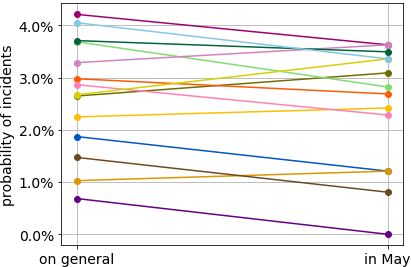

In [22]:
plot_parallel_comparison("df['month'] == 5", "in May", year=2018)

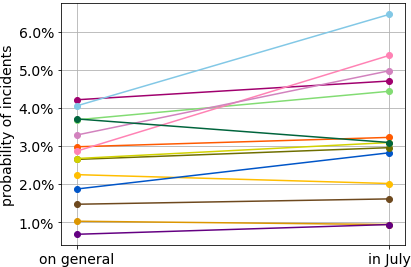

In [23]:
plot_parallel_comparison("df['month'] == 7", "in July", year=2018)

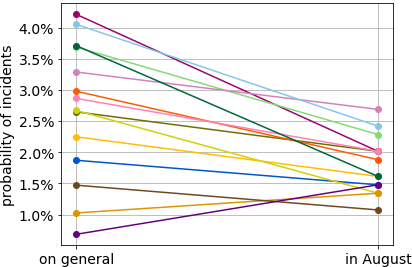

In [24]:
plot_parallel_comparison("df['month'] == 8", "in August", year=2018)

## Work in progress

<Figure size 432x288 with 0 Axes>

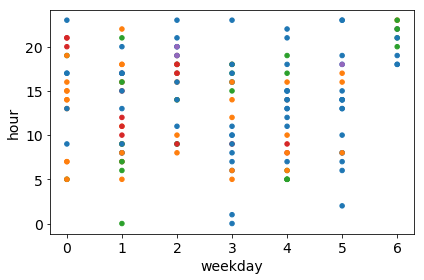

In [116]:
year = 2018
df_resampled = line2._df_processed_loc_year(year)
df_incident = df_resampled[df_resampled["is_incident"] == True]
causes = list(line2.plot_cause(year=year)[0])
colors = [f"C{i}" for i in range(len(causes))]
color_of_cause = dict(zip(causes, colors))
colors_incident = df_incident["incident_cause"].map(color_of_cause).values
plt.clf()
df_incident.plot.scatter("weekday", "hour", c=colors_incident)
plt.tight_layout()